### Deep Learning for Conservation: Classifying Drone Images from Protected Lands
Classification of [Cactus Aerial Images](https://www.kaggle.com/datasets/irvingvasquez/cactus-aerial-photos)

by Jenica Andersen July 22, 2023

I tried numerous model versions. My model here was based on the tutorial found here:
https://keras.io/examples/vision/image_classification_from_scratch/

In [1]:
# bring in the necessary imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
# standardize the image size. My images are small so 32x32 is the size  work with (originals range from 
image_size = (32, 32)
#train with batches to use less memory and for faster training. Training set size is divisible by batch size. Good.  
batch_size = 50

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cactus_data_import", #In this folder there are two subfolders, "1" and "0" containing all of our positive and negative class images, respectively
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cactus_data_import",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

Found 21500 files belonging to 2 classes.
Using 17200 files for training.


2022-10-07 09:49:00.139951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 21500 files belonging to 2 classes.
Using 4300 files for validation.


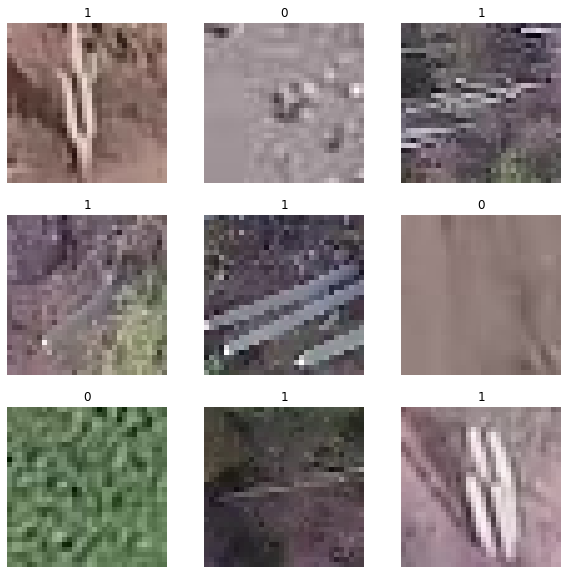

In [3]:
#Plot a sample of the training images for quick inspection
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
#instantiate data augmentation. Applied to training data to prevent overfitting
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(height_factor = (-0.2, 0.3)),#this one does not produce the while_loop warning 
        layers.RandomContrast(factor = 0.2 ),
        layers.RandomBrightness(factor = 0.2),
    ]
)

In [13]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

NameError: name 'ImageDataGenerator' is not defined

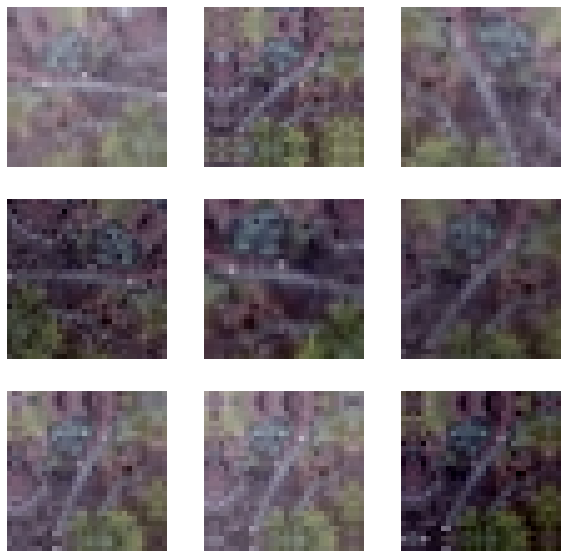

In [5]:
#plot example of augmentation for quick inspection
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [6]:
#augment training data
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

In [7]:
#Use buffered prefetching so we can yield data from disk without input/output becoming blocked:
train_ds = augmented_train_ds.prefetch(buffer_size=50) #buffer size is same as batch size
val_ds = val_ds.prefetch(buffer_size=50)

In [8]:
def cnn_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x) 
    #Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer 
    #for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number 
    #of training epochs required to train deep networks.

    x = layers.Conv2D(64, 3, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.SeparableConv2D(size, 3, padding="same", activation = 'relu')(x) 
        #if used properly, separableConv2D enhances efficiency without significantly reducing effectiveness. read this for indepth discussion #https://towardsdatascience.com/a-basic-introduction-to-separable-convolutions-b99ec3102728
        x = layers.BatchNormalization()(x)

        x = layers.SeparableConv2D(size, 3, padding="same", activation = 'relu')(x) 
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same", activation = 'relu')(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation = 'sigmoid')(x)
    return keras.Model(inputs, outputs)


model = cnn_model(input_shape=image_size + (3,), num_classes=2)
#keras.utils.plot_model(model, show_shapes=True)

In [10]:
epochs = 60 #A plot of results for 150 epochs shows the lines flatten after 60 epochs, maybe sooner.

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]

my_callbacks = [
#    tf.keras.callbacks.EarlyStopping(patience=5),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.History(),
    tf.keras.callbacks.CSVLogger(filename= "training_csv.csv", separator = ",", append = False),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto', cooldown=1),
]

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
#model.summary()
history = model.fit(
    train_ds, epochs=epochs, callbacks=my_callbacks, validation_data=val_ds,
)

Epoch 1/60
344/344 [==============================] - 74s 204ms/step - loss: 0.2716 - accuracy: 0.8923 - val_loss: 0.5564 - val_accuracy: 0.7516 - lr: 0.0010
Epoch 2/60
344/344 [==============================] - 75s 218ms/step - loss: 0.1890 - accuracy: 0.9240 - val_loss: 0.3953 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 3/60
344/344 [==============================] - 73s 212ms/step - loss: 0.1570 - accuracy: 0.9390 - val_loss: 0.1143 - val_accuracy: 0.9574 - lr: 0.0010
Epoch 4/60
344/344 [==============================] - 75s 218ms/step - loss: 0.1611 - accuracy: 0.9380 - val_loss: 0.2039 - val_accuracy: 0.9228 - lr: 0.0010
Epoch 5/60
344/344 [==============================] - 76s 220ms/step - loss: 0.1250 - accuracy: 0.9534 - val_loss: 0.1827 - val_accuracy: 0.9270 - lr: 0.0010
Epoch 6/60
344/344 [==============================] - 76s 221ms/step - loss: 0.1212 - accuracy: 0.9540 - val_loss: 0.1285 - val_accuracy: 0.9495 - lr: 0.0010
Epoch 7/60
344/344 [==============================] 

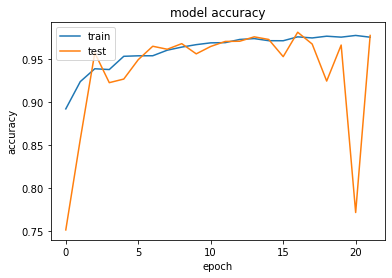

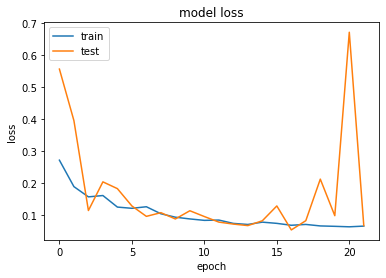

In [11]:
#this code from https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
#summarize history for model accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
#check results for an individual image 
img = keras.preprocessing.image.load_img(
    "test_images/Sinplanta-11.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent likely non-cactus and %.2f percent likely a cactus."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 28ms/step
This image is 83.64 percent likely non-cactus and 16.36 percent likely a cactus.


In [52]:
best_model_weights = './base.model'
checkpoint = ModelCheckpoint(
    best_model_weights,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    save_freq=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.01,
    patience=10,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
#    batch_size=16,
    write_graph=True,
#    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.csv",
    separator = ",",
    append = False
)

#lrsched = LearningRateScheduler(step_decay,verbose=1)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto',
    cooldown=1 
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

NameError: name 'ModelCheckpoint' is not defined

In [51]:
history = model.fit(
    train_ds, 
    validation_data = val_ds,
    validation_steps = 100,
#    steps_per_epoch  = 100, 
    epochs = 10,
    verbose = 1,
#    callbacks=callbacks
)

Epoch 1/10
538/538 [==============================] - 76s 140ms/step - loss: 0.0645 - accuracy: 0.9780 - val_loss: 0.1653 - val_accuracy: 0.9484
Epoch 2/10
538/538 [==============================] - 73s 136ms/step - loss: 0.0657 - accuracy: 0.9776 - val_loss: 0.4055 - val_accuracy: 0.8938
Epoch 3/10
538/538 [==============================] - 73s 136ms/step - loss: 0.0604 - accuracy: 0.9794 - val_loss: 1.2378 - val_accuracy: 0.7631
Epoch 4/10
538/538 [==============================] - 73s 135ms/step - loss: 0.0565 - accuracy: 0.9814 - val_loss: 0.0673 - val_accuracy: 0.9753
Epoch 5/10
538/538 [==============================] - 73s 135ms/step - loss: 0.0491 - accuracy: 0.9832 - val_loss: 0.1974 - val_accuracy: 0.9431
Epoch 6/10
538/538 [==============================] - 81s 150ms/step - loss: 0.0533 - accuracy: 0.9831 - val_loss: 0.0930 - val_accuracy: 0.9681
Epoch 7/10
538/538 [==============================] - 79s 147ms/step - loss: 0.0448 - accuracy: 0.9849 - val_loss: 0.1870 - val_ac

In [50]:
#not working in this notebook
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
#    ax[0].plot.axis([0, 150, 0, 1])
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Train acc")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation acc")
#    ax[0].plot.axis([0, 150, .50, 1])
    ax[0].legend()
    ax[1].legend()


NameError: name 'best_model_weights' is not defined

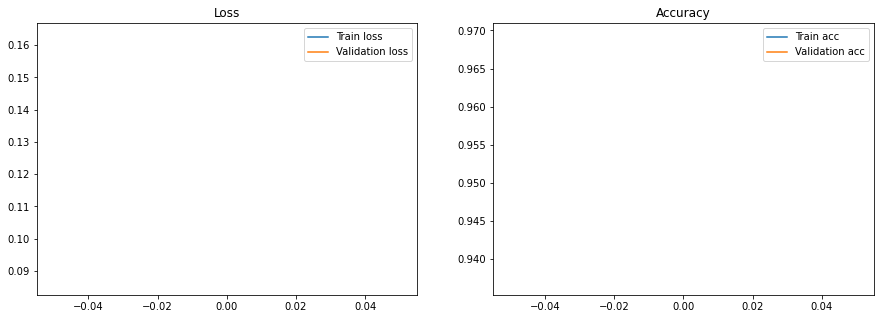

In [51]:
#Not working in this notebook
show_final_history(history)
model.load_weights(best_model_weights)
model_eval = model.evaluate(test_data,steps=100)
print("Model Test Loss:",model_eval[0])
print("Model Test Accuracy:",model_eval[1])

#model_json = model.to_json()
#with open("model.json","w") as json_file:
#    json_file.write(model_json)
    
model.save("model.h5")
print("Weights Saved")

## Now trying to merge transfer learning with own model
my work-in-progress model was predicting my own images as being very cactus like. My idea here was to establish an "if likelihood of this image being cactus is >= x%, then pass it through the mobilenet_v2 model. If something other than window_screen, shower_curtain, prison, window_shade, or crossword_puzzle was predicted, flag the image for inspection.. to see how we could improve the model. However, with improvements, my model was performing well enough that this was fairly moot.

In [26]:
# The following code was borrowed from Metis course material. 
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.preprocessing import image
import numpy as np


#Mobilenet_v2 convolutional neural network/transfer learning model (which was trainined on the ImageNet database).
def prepare_image(img_path): 

    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = mobilenet_v2.preprocess_input(x)
    return x

In [34]:
#This is from the I built model above. 
#here I will bring in my own images to test the binary prediction and the imagenet prediction (below). 
img_path = "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/test_images/Q.jpg"
img = keras.preprocessing.image.load_img(
    "/Users/vesper/Documents/Metis/Module_6_Deep_Learning_Neural_Networks/Cactus_Classification_Dataset/test_images/Q.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent likely non-cactus and %.2f percent likely cactus."
    % (100 * (1 - score), 100 * score)
)

1/1 [==============================] - 0s 204ms/step
This image is 0.00 percent likely non-cactus and 100.00 percent likely cactus.


In [35]:
#This Instantiates the transfer learning model. The output is the model's predicted classifications, descriptions and score. 

model2 = mobilenet_v2.MobileNetV2(weights='imagenet',)#the "weights" here is where the imagenet transfer learning takes place. I will bring in the cacti training images as one of the next steps (once I learn how to do that appropriately)

x = prepare_image(img_path) 

out = model2.predict(x)

print('Predicted:', mobilenet_v2.decode_predictions(out))

1/1 [==============================] - 2s 2s/step
Predicted: [[('n04592741', 'wing', 0.75607806), ('n09472597', 'volcano', 0.061720416), ('n02690373', 'airliner', 0.011936254), ('n03773504', 'missile', 0.007007342), ('n02687172', 'aircraft_carrier', 0.0069040144)]]


![test_image](test_images/U.jpg)

### This is now experimenting with dense layers vs the convolution layers I've been using above. 

In [120]:
#try this for a basic kind of comparison
#input_shape=(train_ds.shape[1], 1)
input_shape = (32,32,3)
NN = tf.keras.models.Sequential()
NN.add(tf.keras.layers.Conv2D(32, (3, 3), input_shape = input_shape, activation = 'relu'))
NN.add(tf.keras.layers.Dense(1024, activation = 'relu')) # need feature input dim (28x28) for first hidden layer
#NN.add(tf.keras.layers.Dropout(0.2))
#    model.add(tf.keras.layers.Dense(512))
NN.add(tf.keras.layers.Dense(512, activation = 'relu'))
#NN.add(tf.keras.layers.Dense(256, activation = 'relu'))      
NN.add(tf.keras.layers.Dense(128, activation = 'relu'))
#NN.add(tf.keras.layers.Dense(64, activation = 'relu'))       
NN.add(tf.keras.layers.Dense(32, activation = 'relu'))       
#NN.add(tf.keras.layers.Dense(16, activation = 'relu'))       
#NN.add(tf.keras.layers.Dense(8, activation = 'relu'))       
#NN.add(tf.keras.layers.Dense(4, activation = 'relu'))              
#NN.add(tf.keras.layers.Dense(2, activation = 'relu'))       
NN.add(tf.keras.layers.Flatten())              
NN.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))              

NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
#NN.fit(train_ds, y_train_cat, epochs=20, batch_size=512, verbose=1) # track progress as we fit
NN.fit(train_ds, epochs=2, callbacks=callbacks, validation_data=val_ds,)
#first run, 2 epochs, 7 layers took 10 minutes

Epoch 1/2
538/538 [==============================] - 286s 530ms/step - loss: 0.4328 - accuracy: 0.8735 - val_loss: 0.2534 - val_accuracy: 0.9100
Epoch 2/2
538/538 [==============================] - 312s 580ms/step - loss: 0.2288 - accuracy: 0.9140 - val_loss: 0.1361 - val_accuracy: 0.9484


In [ ]:
input_shape=(X_train.shape[1], 1)